# Custom pipeline

In *prose*, `~prose.Block`{.interpreted-text role="class"} objects (which are dedicated to image analysis and/or modification) can be aranged into `~prose.Unit`{.interpreted-text role="class"} which have the following workflow:

![im1](../_static/unit_structure.png)

By providing [many pre-implemented blocks](../../guide/api/blocks.rst) one can arange a complete pipeline to achieve a specific analysis. `~prose.Block`{.interpreted-text role="class"} can also be implemented to include custom processing.

## Objective

In this tutorial we will create a custom`~prose.Block`{.interpreted-text role="class"} and include it in a pipeline (`~prose.Unit`{.interpreted-text role="class"}) which goal is to detect and trace a moving object in the following observation:

![im2](../_static/moving_dataset_movie.gif)

Dataset
-------
For this tutorial we will work on a synthetic observation which gif can be seen above. To generate this dataset:


In [9]:
from prose.datasets import generate_prose_reduction_dataset

dataset = "moving_object_dataset"
generate_prose_reduction_dataset(dataset, moving=[5, [0,40], [75, 60]], n_images=15)

'/Users/lionelgarcia/Code/prose/docs/source/tutorials/modular-reduction/moving_object_dataset'

We directly instantiate a `~prose.FitsManager`{.interpreted-text role="class"} object to explore this folder (see [Fits Manager](../../api/api/fitsmanager.rst))

In [1]:
from prose import FitsManager
#
fm = FitsManager(dataset)

NameError: name 'dataset' is not defined

In [11]:
# hidden

from prose import Unit
from prose.blocks import Video

u = Unit([
    Video("moving_dataset_movie.gif", factor=2, from_fits=True),
], fm.images)

_ = u.run()

RUN default: 100%|███████████████████████████| 15/15 [00:00<00:00, 72.21files/s]


## Principle

We will use difference imaging to locate the moving object. This is shown in the next code where we can see that difference between consecutive images allow to locate a moving source.

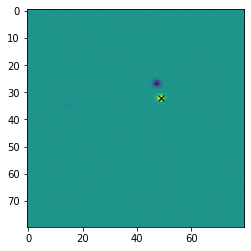

In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# loading first and second images
files = fm.get("light")
im0 = fits.getdata(files[5])
im1 = fits.getdata(files[6])

# difference image
im_diff = im1 - im0

# max difference position
position = np.array(np.unravel_index(np.argmax(im_diff), im_diff.shape))[::-1]

plt.imshow(im_diff)
_ = plt.plot(*position, "x", c="k")

## Creating a new :`~prose.Block`{.interpreted-text role="class"}

Now we can create a `~prose.Block`{.interpreted-text role="class"} (subclass) that will extract and store this information. As a reminder, a block has the following strucure:

![im3](../_static/block_structure.png)

In [14]:
from prose import Block
from prose.utils import z_scale

class MovingTarget(Block):
    
    # nothing to initialize
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # stores last image and positions
        self.last_image = None 
        self.positions = []
        
    def run(self, image):
        
        # difference imaging we did above
        if self.last_image is None:
            self.positions.append(None)
        else:
            im_diff = image.data - self.last_image
            position = np.unravel_index(np.argmax(im_diff), im_diff.shape)[::-1]
            self.positions.append(position)
         
        self.last_image = image.data

    def terminate(self):
        
        # We finish by plotting positions over the last image
        plt.imshow(z_scale(self.last_image), cmap="Greys_r")
        coords_path = np.array(self.positions[1::])
        plt.plot(*coords_path.T, "-o", ms=4)

We can now place our new block in a `~prose.Unit`{.interpreted-text role="class"} and run it:

RUN default: 100%|███████████████████████████| 15/15 [00:00<00:00, 92.38files/s]


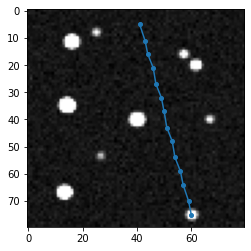

In [15]:
from prose import Unit

pipeline = Unit([
    MovingTarget()
], fm.images)

_ = pipeline.run()

In [16]:
# hidden
from shutil import rmtree

rmtree(dataset)